In [5]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd

# -----------------------------
# FDSN client (EarthScope / IRIS)
# -----------------------------
client = Client("IRIS")

# -----------------------------
# Appalachian region bounding box
# -----------------------------
minlatitude = 32.0
maxlatitude = 42.5
minlongitude = -90.0
maxlongitude = -74.0

# -----------------------------
# Time window (broad query)
# -----------------------------
t_start = UTCDateTime("1990-01-01")
t_end   = UTCDateTime()

# -----------------------------
# Minimum duration threshold
# -----------------------------
#min_years = 2.0
min_years = 1.5
min_seconds = min_years * 365.25 * 24 * 3600

records = []

# -----------------------------
# Query all stations in region (any channel)
# -----------------------------
inventory = client.get_stations(
    minlatitude=minlatitude,
    maxlatitude=maxlatitude,
    minlongitude=minlongitude,
    maxlongitude=maxlongitude,
    channel="BH?,HH?",  # Request both BH* and HH*
    starttime=t_start,
    endtime=t_end,
    level="channel"
)

# -----------------------------
# Parse inventory
# -----------------------------
for network in inventory:
    for station in network:
        # Check which channels are present
        bh_channels = [ch for ch in station.channels if ch.code.startswith("BH")]
        hh_channels = [ch for ch in station.channels if ch.code.startswith("HH")]

        # Skip if neither BH nor HH has 3 components
        if len(bh_channels) < 3 and len(hh_channels) < 3:
            continue

        # Decide which set to use for duration calculation (prefer BH)
        if len(bh_channels) >= 3:
            channels = bh_channels
            channel_type = "BH"
        else:
            channels = hh_channels
            channel_type = "HH"

        # Determine data span across selected channels
        start_times = []
        end_times = []

        for ch in channels:
            if ch.start_date:
                start_times.append(ch.start_date)
            if ch.end_date:
                end_times.append(ch.end_date)
            else:
                end_times.append(t_end)

        if not start_times or not end_times:
            continue

        span = min(end_times) - max(start_times)

        if span >= min_seconds:
            records.append({
                "network": network.code,
                "station": station.code,
                "latitude": station.latitude,
                "longitude": station.longitude,
                "elevation_m": station.elevation,
                "start_date": max(start_times).date,
                "end_date": min(end_times).date,
                "duration_years": span / (365.25 * 24 * 3600),
                "channel_type": channel_type  # New field
            })

# -----------------------------
# Convert to DataFrame
# -----------------------------
df = pd.DataFrame(records).sort_values(
    by="duration_years", ascending=False
)

# -----------------------------
# Output
# -----------------------------
print(f"\nStations with BH* or HH* channels ≥ {min_years} years:\n")
print(df.to_string(index=False))

# Save to CSV
df.to_csv("appalachian_BH_HH_stations_2yr_plus.csv", index=False)



Stations with BH* or HH* channels ≥ 1.5 years:

network station  latitude  longitude  elevation_m start_date   end_date  duration_years channel_type
     PN   PNNAF 38.333000 -85.931000    22.900000 1999-01-01 2026-01-09       27.025102           BH
     PN   PPMUN 40.201000 -85.387001   280.000000 1999-01-01 2026-01-09       27.025102           BH
     PN   PPHHS 37.972000 -87.486000   122.200000 1999-01-01 2026-01-09       27.025102           BH
     PN    PURD 40.438000 -86.946198   207.000000 1999-01-10 2026-01-09       27.000461           BH
     SE    URVA 37.570900 -77.535698    49.000000 2006-01-01 2026-01-09       20.024417           HH
     SS    NCAT 36.078957 -79.771179   243.000000 2009-02-03 2026-01-09       16.933384           BH
     PO    PLIO 41.750500 -82.628403   143.000000 2009-06-03 2026-01-09       16.602995           HH
     GS   DEC06 39.896748 -88.946442   214.763000 2013-10-24 2026-01-09       12.211052           HH
     NW    HQIL 41.799820 -87.853432   193

makecpt [WARNING]: algae is a discrete CPT. You can stretch it (-T<min>/<max>) but not interpolate it (-T<min>/<max>/<inc>).
makecpt [WARNING]: Selecting the given range and ignoring the increment setting.
plot [WARNING]: Cannot use auto-legend -l for variable symbol color. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol color. Option -l ignored.
legend [WARNING]: File <stdin> is empty!


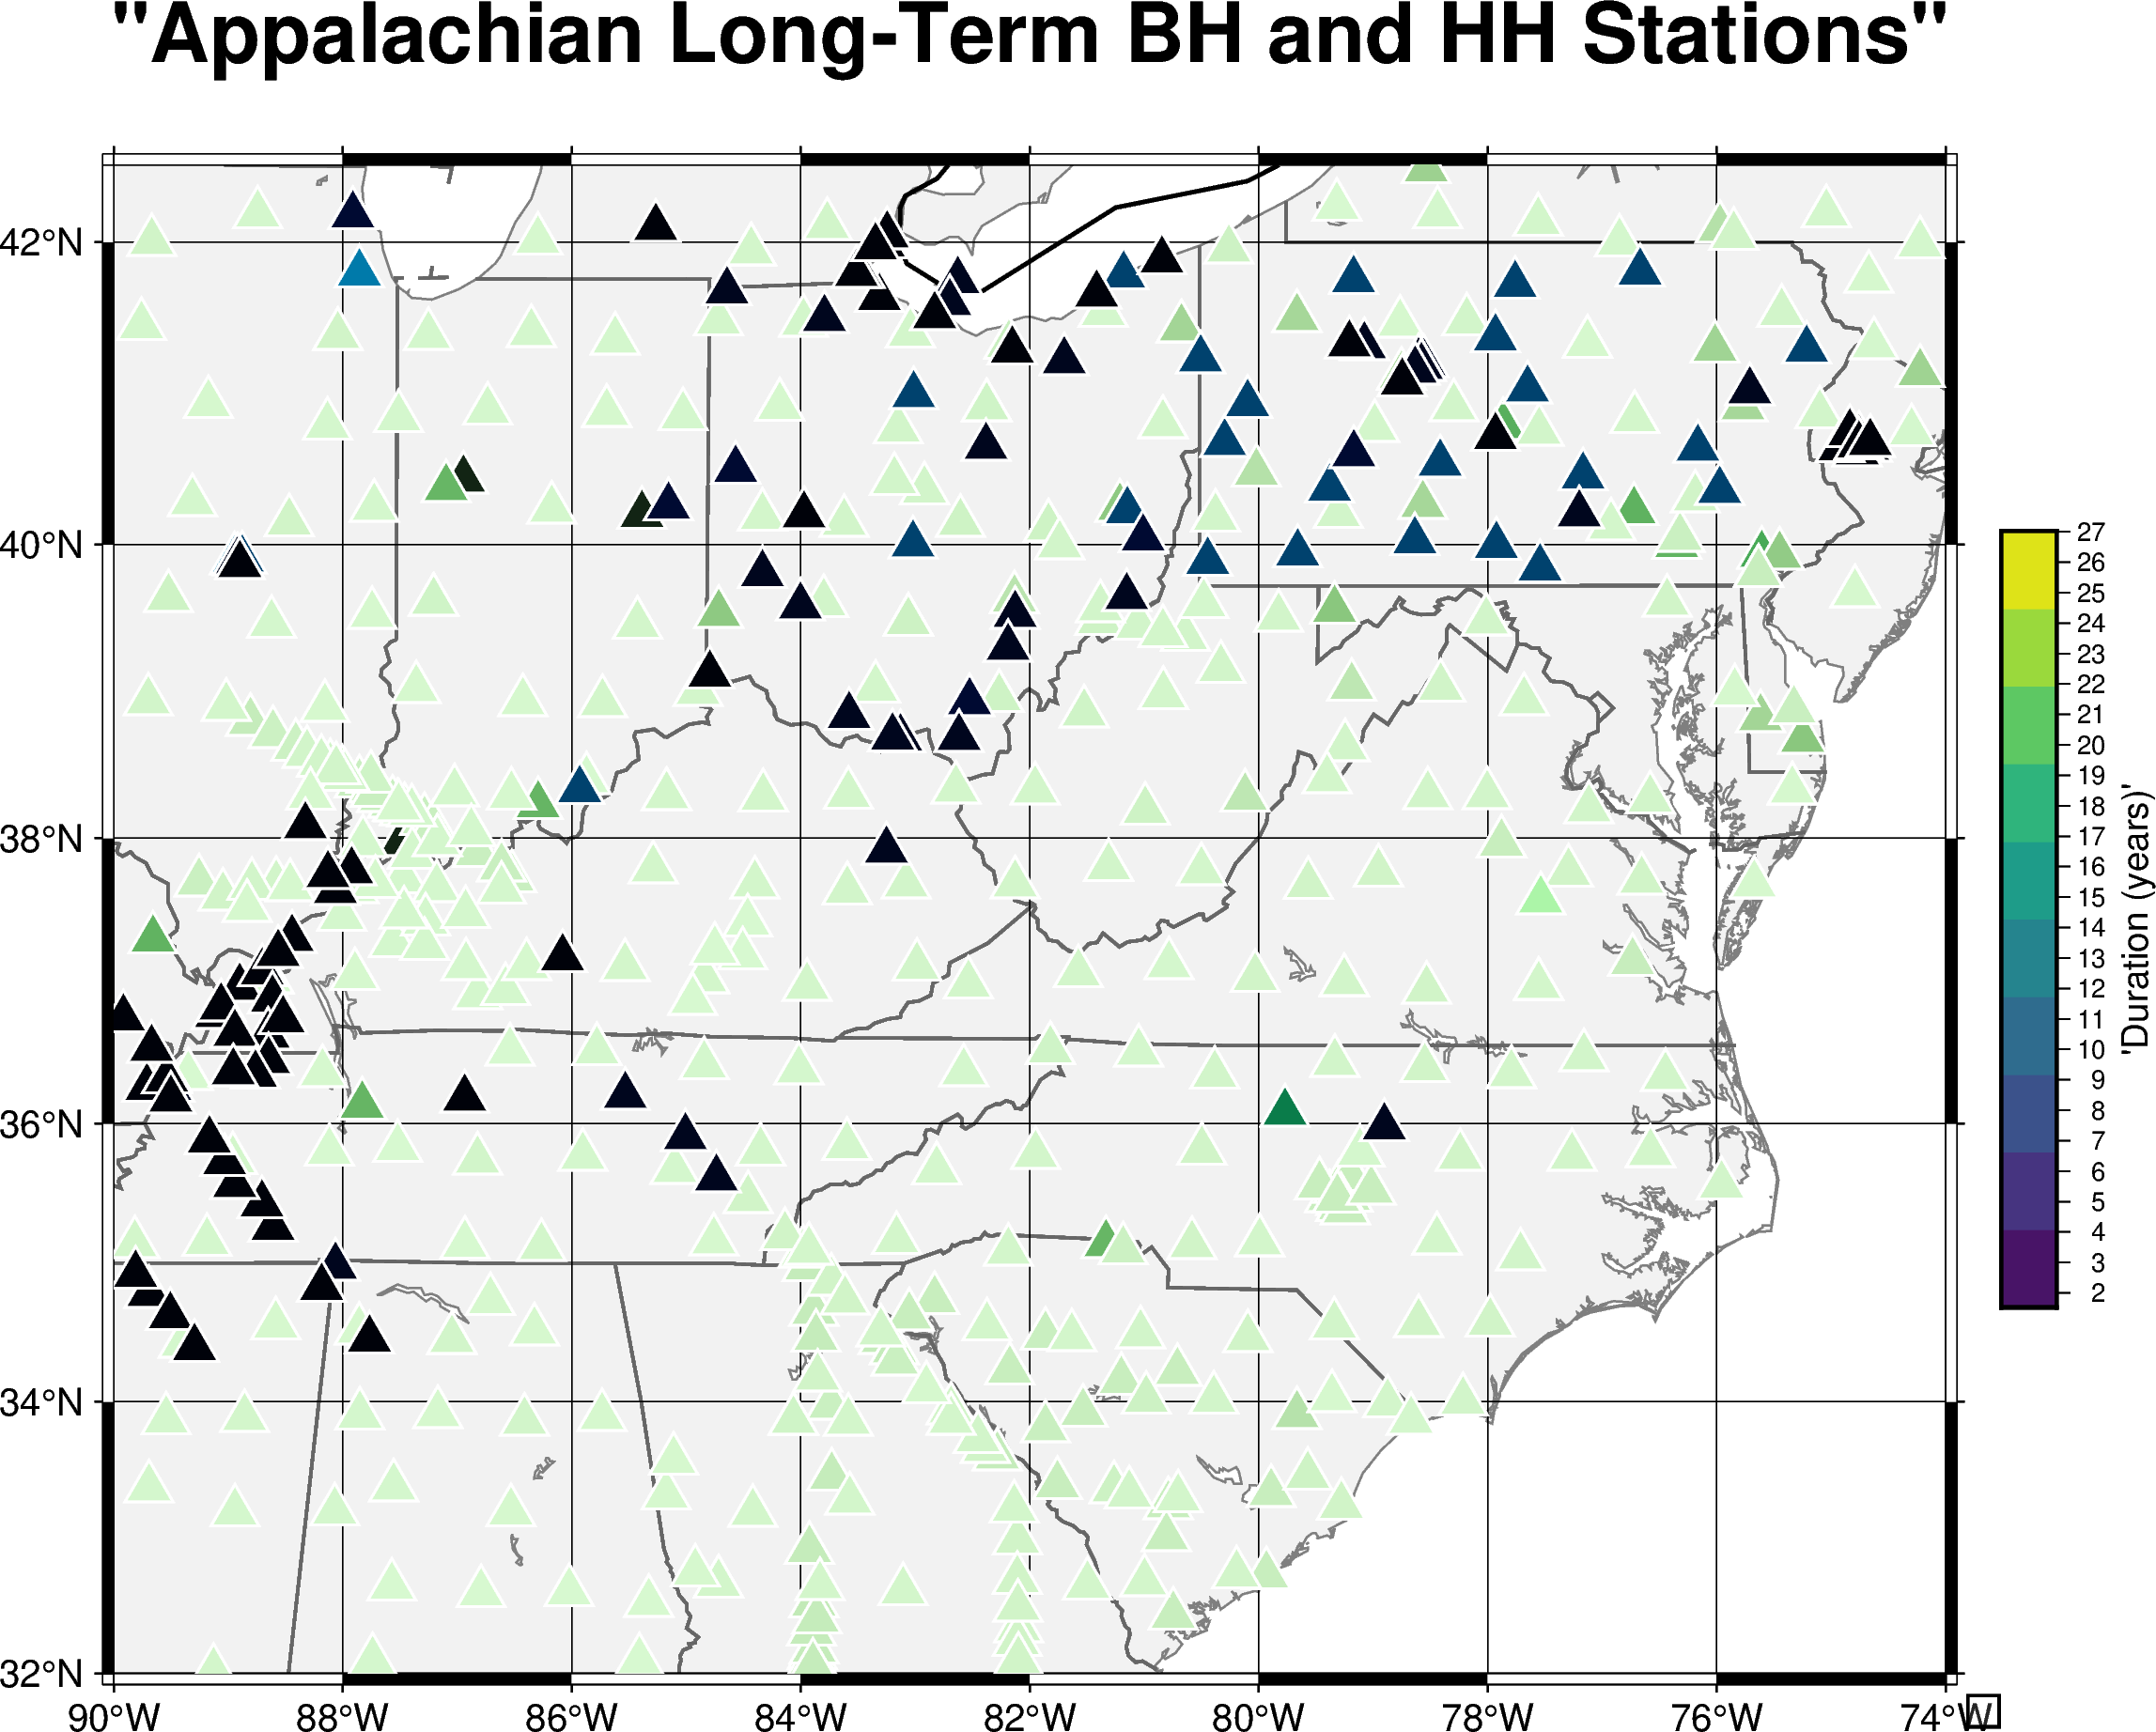

In [6]:
import pygmt
import pandas as pd

# -----------------------------
# Input station CSV
# -----------------------------
station_file = "appalachian_BH_HH_stations_2yr_plus.csv"
df = pd.read_csv(station_file)

# -----------------------------
# Appalachian region
# -----------------------------
region = [-90.0, -74.0, 32, 42.5]
projection = "M6.5i"

# -----------------------------
# Create figure
# -----------------------------
fig = pygmt.Figure()

# -----------------------------
# Basemap
# -----------------------------
fig.coast(
    region=region,
    projection=projection,
    land="gray95",
    water="white",
    borders=[
        "1/1p,black",
        "2/0.8p,gray40"
    ],
    shorelines="0.5p,gray50",
    frame=["ag", 'WSne+t"Appalachian Long-Term BH and HH Stations"']
)

# -----------------------------
# Symbol size (fixed)
# -----------------------------
size = 0.5  # cm

# -----------------------------
# Separate BH and HH stations
# -----------------------------
df_bh = df[df["channel_type"] == "BH"]
df_hh = df[df["channel_type"] == "HH"]

# -----------------------------
# Colormap range based on duration
# -----------------------------
vmin = df["duration_years"].min()
vmax = df["duration_years"].max()

# -----------------------------
# Plot BH stations (green tones, algae)
# -----------------------------
if not df_bh.empty:
    pygmt.makecpt(cmap="algae", series=[vmin, vmax, (vmax-vmin)/10])
    fig.plot(
        x=df_bh["longitude"],
        y=df_bh["latitude"],
        style=f"t{size}c",
        fill=df_bh["duration_years"],
        cmap=True,
        pen="0.6p,white",
        label="BH* stations"
    )

# -----------------------------
# Plot HH stations (blue tones, ocean)
# -----------------------------
if not df_hh.empty:
    pygmt.makecpt(cmap="ocean", series=[vmin, vmax, (vmax-vmin)/10])
    fig.plot(
        x=df_hh["longitude"],
        y=df_hh["latitude"],
        style=f"t{size}c",
        fill=df_hh["duration_years"],
        cmap=True,
        pen="0.6p,white",
        label="HH* stations"
    )

# -----------------------------
# Colorbar (generic viridis for clarity)
# -----------------------------
pygmt.makecpt(cmap="viridis", series=[vmin, vmax, (vmax-vmin)/10])
fig.colorbar(
    frame=f"a1f1+l'Duration (years)'",
    position="JMR+o0.5c/0c+w7c/0.5c"
)

# -----------------------------
# Legend
# -----------------------------
fig.legend(
    position="JBR+o0.2c",
    box="+gwhite@85+p0.8p"
)

# -----------------------------
# Save figure
# -----------------------------
fig.savefig("appalachian_BH_HH_stations_colored.png", dpi=300)
fig.show()
